# Sentinels feature engineering
This notebook perform the following steps:

Read all available visual and SCL(scene classification) layers.
Mask out the non-water regions by applying the mask created by selecting SCL==6 (water pixels).
Extract water-related color features.

In [1]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
import tqdm
import cv2
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
from scipy.stats import kruskal

In [2]:
# read competition related files
meta = pd.read_csv('../inputs/metadata.csv')
train = meta.copy()
train.head(2)

train_label = pd.read_csv('../inputs/train_labels.csv')
test_pslabel = pd.read_csv('../inputs/submission_format.csv')

water_files = set(glob.glob('../downloaded_data/Sentinel/W_*.png'))
all_files = set(glob.glob('../downloaded_data/Sentinel/*.png'))
imgs = list(all_files - water_files)

print('Downloaded Sentinels files: {}, water mask: {}, img: {}'.format(
    len(all_files), len(water_files), len(imgs)))

df = pd.DataFrame({'files': list(water_files)})
df['uid'] = df.files.str.split('_', expand=True)[2]

lbls = pd.concat([test_pslabel, train_label])

train = train.merge(df, on='uid', how='inner').merge(lbls, on='uid', how='inner')
train['path'] = train.files.apply(lambda x: x.replace('W_', ''), 1)


interested = train.copy()

Downloaded Sentinels files: 30047, water mask: 15023, img: 15024


In [3]:
interested.split.value_counts()

train    10595
test      4428
Name: split, dtype: int64

In [4]:
r,g,b,gmax,gmin = [], [], [], [], []
for i, row in interested.iterrows():
    wm = imread(row.files)
    img = imread(row.path)
    water_scaled = np.stack([cv2.resize(wm, (img.shape[1], img.shape[0]))] * 3, -1) == 6
    if water_scaled.sum() == 0:
        r.append(np.nan)
        g.append(np.nan)
        b.append(np.nan)
        gmax.append(np.nan)
        gmin.append(np.nan)
    else:
        r.append(img[:, :, 0][water_scaled[:, :, 0]].mean())
        g.append(img[:, :, 1][water_scaled[:, :, 1]].mean())
        b.append(img[:, :, 2][water_scaled[:, :, 2]].mean())
        gmax.append(np.percentile(img[:, :, 1][water_scaled[:, :, 1]], 95))
        gmin.append(np.percentile(img[:, :, 1][water_scaled[:, :, 1]], 5))


In [9]:
interested['R'] = r
interested['G'] = g
interested['B'] = b
interested['GMax'] = gmax
interested['GMin'] = gmin


interested['G_R'] = interested.G / interested.R
interested['G_B'] = interested.G / interested.B
interested['R_B'] = interested.R / interested.B
interested['GMax_B'] = interested.GMax / interested.B
interested['GMin_B'] = interested.GMin / interested.B

In [10]:
interested.to_csv('../outputs/Sentinels_available_features.csv', index=False)

In [11]:
np.abs(interested[
    (interested.split == 'train') & (interested.region.isin(['midwest', 'northeast']))
].corr()[['severity']]).sort_values('severity')

/tmp/ipykernel_702581/2161233432.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  np.abs(interested[


,severity
G_R,0.098202
GMax_B,0.104874
B,0.133577
GMax,0.160454
R,0.175333
GMin_B,0.225835
G,0.241006
GMin,0.253939
R_B,0.263560
G_B,0.306651


<AxesSubplot: xlabel='severity', ylabel='G_B'>

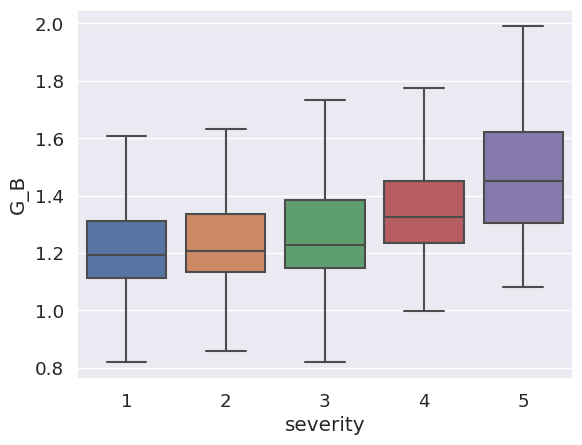

In [12]:
sns.set(font_scale=1.2)
sns.boxplot(data=interested, x='severity', y='G_B', showfliers = False)